In [31]:
import pandas as pd

import numpy as np

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import seaborn as sn

import random
import os

In [32]:
sequence_path = "../chr_seq/"
annotation_path = "../combined_annotations.csv"

In [33]:
annotations = pd.read_csv(annotation_path, sep='\t')

In [34]:
annotations['label'] = annotations['label'].replace('junk', 'non-target')

In [35]:
annotations

,chrom,frameStart,frameEnd,label
0,chr1,181248,181648,enhP
1,chr1,182069,182469,non-target
2,chr1,190745,191145,enhD
3,chr1,701385,701785,non-target
4,chr1,778561,778961,prom
...,...,...,...,...
1424268,chrY,56849895,56850295,non-target
1424269,chrY,56857336,56857736,CTCF
1424270,chrY,56857785,56858185,CTCF
1424271,chrY,56863046,56863446,non-target


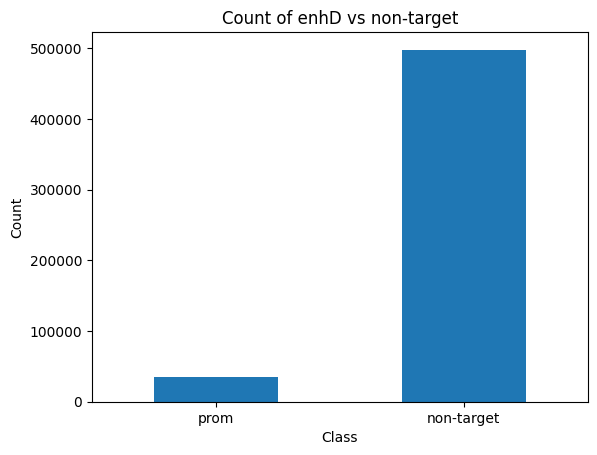

In [36]:
# # Count the occurrences of each class
# class_counts = annotations['label'].value_counts()
# class_counts['rest'] = class_counts.drop('enhD').sum()
# class_counts = class_counts[['enhD', 'rest']]

# # Plot the counts
# class_counts.plot(kind='bar')
# plt.title('Count of enhD vs Rest')
# plt.xlabel('Class')
# plt.ylabel('Count')
# plt.xticks(rotation=0)  # Rotate x-axis labels to show them horizontally
# plt.show()

class_counts = annotations['label'].value_counts()
class_counts = class_counts[['prom', 'non-target']]

# Plot the counts
class_counts.plot(kind='bar')
plt.title('Count of enhD vs non-target')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels to show them horizontally
plt.show()



In [37]:
annotations=annotations[annotations['label'].isin(['prom', 'non-target'])]

In [38]:
# Count the number of 'prom' annotations
num_prom = len(annotations[annotations['label'] == 'prom'])

# Randomly sample 'non-target' annotations to match the number of 'prom' annotations
nt_annotations_sampled = annotations[annotations['label'] == 'non-target'].sample(n=num_prom, random_state=42)

# Combine the two sets
annotations = pd.concat([annotations[annotations['label'] == 'prom'], nt_annotations_sampled])

# Now you can proceed to create your dataset with 'balanced_annotations'
# instead of the full 'annotations' DataFrame

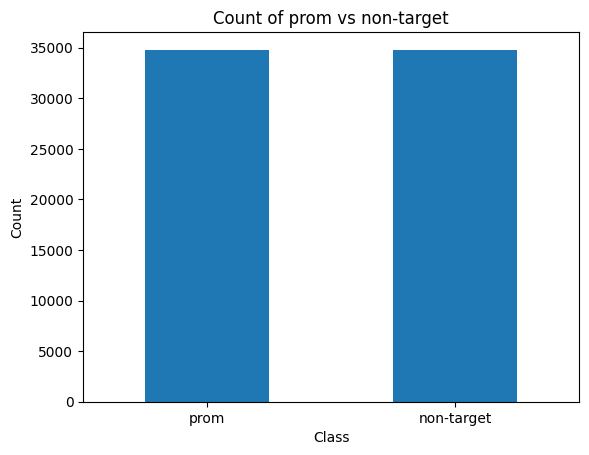

In [39]:
class_counts = annotations['label'].value_counts()

# Plot the counts
class_counts.plot(kind='bar')
plt.title('Count of prom vs non-target')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels to show them horizontally
plt.show()



In [40]:
annotations.head()

,chrom,frameStart,frameEnd,label
4,chr1,778561,778961,prom
5,chr1,779047,779447,prom
14,chr1,817029,817429,prom
23,chr1,827291,827691,prom
48,chr1,870102,870502,prom


In [41]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd


class DNADataset(Dataset):
    def __init__(self, sequence, annotations, encoding_type='integer'):
        self.sequence = sequence
        self.annotations = annotations
        self.encoding_type = encoding_type
        self.sections = self._extract_sections()
    
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):     
        start, end, label = self.sections[index]
        sequence_section = self.sequence[start:end]
        sequence_section = [self._map_dna_letter(letter) for letter in sequence_section]
        sequence_section = torch.tensor(sequence_section).T
        
        return sequence_section, label
    
    def _extract_sections(self):
        sections = []
        # Iterate over each annotation
        for _, row in self.annotations.iterrows():
            start = row['frameStart']
            end = row['frameEnd']
            label = self._map_annotation_type(row['label'])
            sections.append((start, end, label))
        return sections

    def _map_dna_letter(self, letter):
        if self.encoding_type == 'integer':
            if letter == 'A':
                return 1
            elif letter == 'C':
                return 2
            elif letter == 'G':
                return 3
            elif letter == 'T':
                return 4
            elif letter == 'N':
                return 5
            else:
                raise ValueError(f"Invalid DNA letter: {letter}")
        elif self.encoding_type == 'one_hot':
            if letter == 'A':
                return [1, 0, 0, 0]
            elif letter == 'C':
                return [0, 1, 0, 0]
            elif letter == 'G':
                return [0, 0, 1, 0]
            elif letter == 'T':
                return [0, 0, 0, 1]
            elif letter == 'N':
                return [0, 0, 0, 0]
            else:
                raise ValueError(f"Invalid DNA letter: {letter}")
        else:
            raise ValueError(f"Invalid encoding type: {self.encoding_type}")
    
    @staticmethod
    def _map_annotation_type(annotation_type):
        if annotation_type == 'prom':
            return 1
        elif annotation_type == 'non-target':
            return 0

In [42]:
# Create a list of chromosome names including chrX and chrY
chr_sequences = [f'chr{i}' for i in range(1, 23)] + ['chrX', 'chrY']

dataset = []

for seq in chr_sequences:
    # Read DNA sequence file
    print(f'Processing {seq}...')
    sequence_file_path = f'{sequence_path}/{seq}.fa'
    annotations_for_seq = annotations[annotations['chrom'] == seq]
    print(f'Number of annotations for {seq}: {annotations_for_seq.shape[0]}')
    
    with open(sequence_file_path, 'r') as file:
        # Skip the first line which is the header
        next(file)
        # Read the sequence, remove newlines and convert to uppercase
        dna_sequence = file.read().replace("\n", "").upper()
        
        # Initialize the dataset for this chromosome with its annotations
        ds = DNADataset(dna_sequence, annotations_for_seq, encoding_type='one_hot')
        # Extend the main dataset with the data from this chromosome
        dataset.extend(ds)

# Split into training and testing sets (adjust ratios as per your needs)
train_size = int(0.9 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])



Processing chr1...
Number of annotations for chr1: 6300
Processing chr2...
Number of annotations for chr2: 5333
Processing chr3...
Number of annotations for chr3: 4425
Processing chr4...
Number of annotations for chr4: 3334
Processing chr5...
Number of annotations for chr5: 3626
Processing chr6...
Number of annotations for chr6: 4030
Processing chr7...
Number of annotations for chr7: 3543
Processing chr8...
Number of annotations for chr8: 3082
Processing chr9...
Number of annotations for chr9: 2735
Processing chr10...
Number of annotations for chr10: 2987
Processing chr11...
Number of annotations for chr11: 3719
Processing chr12...
Number of annotations for chr12: 3659
Processing chr13...
Number of annotations for chr13: 1661
Processing chr14...
Number of annotations for chr14: 2421
Processing chr15...
Number of annotations for chr15: 2237
Processing chr16...
Number of annotations for chr16: 2593
Processing chr17...
Number of annotations for chr17: 3343
Processing chr18...
Number of an

In [43]:
# # Save datasets
# torch.save(train_dataset, 'train_dataset.pt')
# torch.save(test_dataset, 'test_dataset.pt')


In [44]:
# train_dataset = torch.load('train_dataset.pt')
# test_dataset = torch.load('test_dataset.pt')

In [45]:
train_dataset.__len__()

62645

In [46]:
print(train_dataset.__getitem__(1))

(tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 1,  ..., 0, 0, 1],
        [0, 1, 0,  ..., 0, 1, 0]]), 1)


In [54]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv1d(4, 32, kernel_size=3, stride=1, padding=1)
#         self.pool1 = nn.MaxPool1d(kernel_size=2)
#         self.conv2 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding=1)
#         self.pool2 = nn.MaxPool1d(kernel_size=2)
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(32 * 100, 100)
#         self.dropout = nn.Dropout(0.8)
#         self.fc2 = nn.Linear(100, 50)
#         self.fc3 = nn.Linear(50, 2)
#         # self.softmax = nn.Softmax(dim=1)

    
#     def forward(self, x):
#         x = self.pool1(nn.functional.relu(self.conv1(x)))
#         x = self.pool2(nn.functional.relu(self.conv2(x)))
#         x = self.flatten(x)
#         x = nn.functional.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = nn.functional.relu(self.fc2(x))
#         x = self.fc3(x)
#         # x = self.softmax(x)
#         return x

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(4, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 50, 128)  # Assuming max pooling is applied 3 times
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(self.dropout(x)))
        x = nn.functional.relu(self.fc2(self.dropout(x)))
        x = self.fc3(x)
        return x


In [65]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define the training parameters
batch_size = 128
num_epochs = 20
learning_rate = 0.0001

# Create DataLoader instances for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




In [66]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device


device(type='cpu')

Epoch 1/20:
Train Loss: 0.4753, Train Accuracy: 0.7700
Test Loss: 0.3845, Test Accuracy: 0.8289
ROC AUC: 0.9008

Epoch 2/20:
Train Loss: 0.3848, Train Accuracy: 0.8266
Test Loss: 0.3647, Test Accuracy: 0.8355
ROC AUC: 0.9097

Epoch 3/20:
Train Loss: 0.3669, Train Accuracy: 0.8349
Test Loss: 0.3501, Test Accuracy: 0.8437
ROC AUC: 0.9173

Epoch 4/20:
Train Loss: 0.3552, Train Accuracy: 0.8415
Test Loss: 0.3432, Test Accuracy: 0.8461
ROC AUC: 0.9228

Epoch 5/20:
Train Loss: 0.3446, Train Accuracy: 0.8463
Test Loss: 0.3325, Test Accuracy: 0.8497
ROC AUC: 0.9267

Epoch 6/20:
Train Loss: 0.3372, Train Accuracy: 0.8499
Test Loss: 0.3265, Test Accuracy: 0.8502
ROC AUC: 0.9294

Epoch 7/20:
Train Loss: 0.3320, Train Accuracy: 0.8517
Test Loss: 0.3208, Test Accuracy: 0.8561
ROC AUC: 0.9314

Epoch 8/20:
Train Loss: 0.3273, Train Accuracy: 0.8548
Test Loss: 0.3308, Test Accuracy: 0.8469
ROC AUC: 0.9331

Epoch 9/20:
Train Loss: 0.3221, Train Accuracy: 0.8559
Test Loss: 0.3137, Test Accuracy: 0.8569


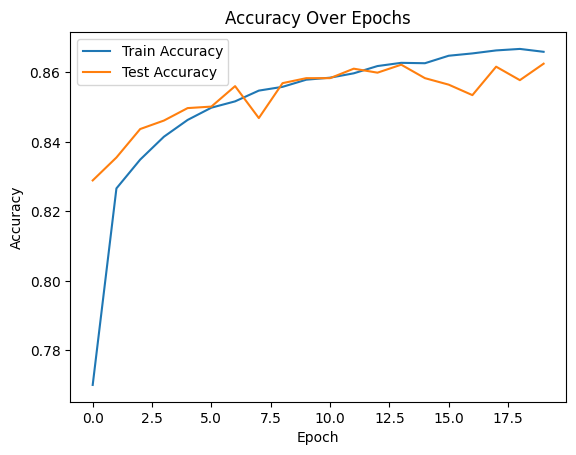

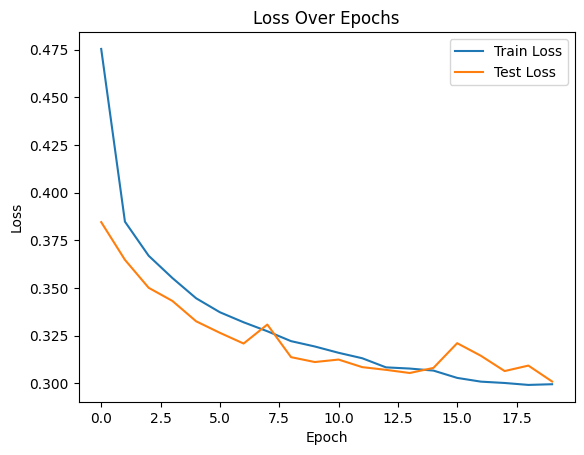

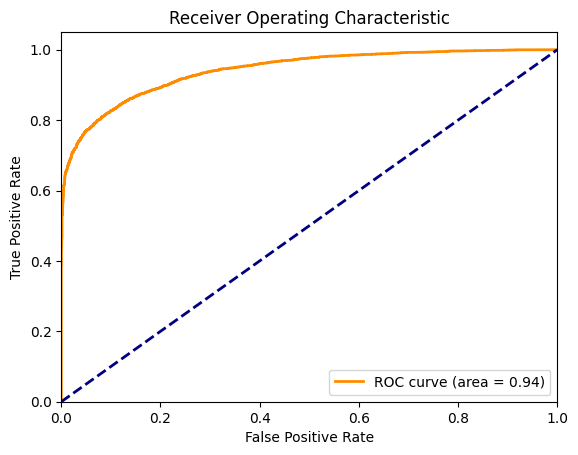

In [67]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Create an instance of the CNN model
model = CNN()
model.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_losses_per_epoch, train_accuracies_per_epoch = [], []
test_losses_per_epoch, test_accuracies_per_epoch = [], []
fpr_list, tpr_list, roc_auc_list = [], [], []  # For ROC curves

# Adjusted training loop
for epoch in range(num_epochs):
    model.train()
    total_loss, correct_predictions = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.float().to(device), labels.long().to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    avg_train_loss = total_loss / len(train_loader.dataset)
    train_accuracy = correct_predictions / len(train_loader.dataset)
    train_losses_per_epoch.append(avg_train_loss)
    train_accuracies_per_epoch.append(train_accuracy)
    
    # Evaluate on test set after each epoch
    model.eval()
    total_loss, correct_predictions, all_targets, all_probabilities = 0, 0, [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.float().to(device), labels.long().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

            # For ROC curve
            probabilities = nn.functional.softmax(outputs, dim=1)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    avg_test_loss = total_loss / len(test_loader.dataset)
    test_accuracy = correct_predictions / len(test_loader.dataset)
    test_losses_per_epoch.append(avg_test_loss)
    test_accuracies_per_epoch.append(test_accuracy)

    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(all_targets, all_probabilities)
    roc_auc = auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}\n")

# Plot training and test accuracies
plt.plot(train_accuracies_per_epoch, label='Train Accuracy')
plt.plot(test_accuracies_per_epoch, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

# Plot training and test losses
plt.plot(train_losses_per_epoch, label='Train Loss')
plt.plot(test_losses_per_epoch, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

# Plot the ROC curve (using the last epoch's data)
plt.plot(fpr_list[-1], tpr_list[-1], color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_list[-1]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Test Loss: 0.3009, Test Accuracy: 0.8625


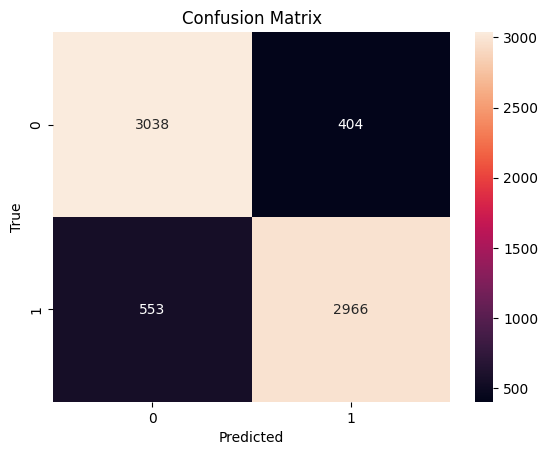

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      3442
           1       0.88      0.84      0.86      3519

    accuracy                           0.86      6961
   macro avg       0.86      0.86      0.86      6961
weighted avg       0.86      0.86      0.86      6961



In [68]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

model.eval()  # Set the model to evaluation mode
total_loss = 0.0
correct_predictions = 0
all_predicted_labels = []
all_true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.float().to(device), labels.long().to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

avg_loss = total_loss / len(test_loader.dataset)
accuracy = correct_predictions / len(test_loader.dataset)
# test_losses.append(avg_loss)
# test_accuracies.append(accuracy)

print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Confusion matrix
confusion_mtx = confusion_matrix(all_true_labels, all_predicted_labels)
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(all_true_labels, all_predicted_labels))

# Suggestions for further improvements in elegance:
# 1. Function Definitions: Consider defining functions for repetitive tasks like plotting or calculating metrics.
# 2. Early Stopping: Implement early stopping during training to prevent overfitting.
# 3. Logging: Use a logging library instead of print statements for better control over the logging level and formatting.



In [ ]:
class_counts